In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, log_loss, f1_score, classification_report
from sklearn.base import clone 
from lightgbm import LGBMClassifier
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [3]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

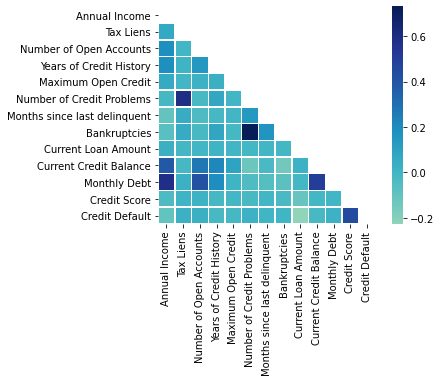

In [4]:
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, center=0, linewidths=.5, cmap='YlGnBu');

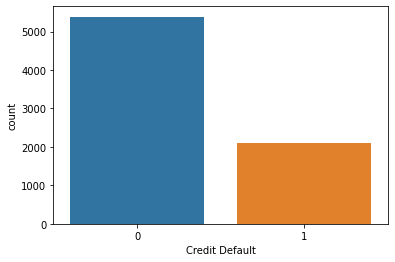

In [5]:
sns.countplot(train['Credit Default']);

In [6]:
train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

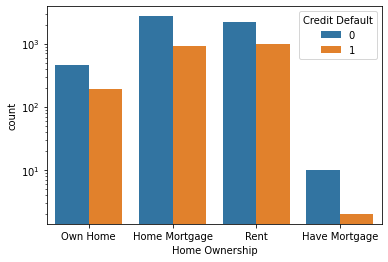

In [7]:
sns.countplot(train['Home Ownership'], hue=train['Credit Default'], log=True);

In [8]:
train['Home Ownership'].value_counts(normalize=True)

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64

In [9]:
train.groupby(['Home Ownership'])['Credit Default'].mean()

Home Ownership
Have Mortgage    0.166667
Home Mortgage    0.251856
Own Home         0.296754
Rent             0.313046
Name: Credit Default, dtype: float64

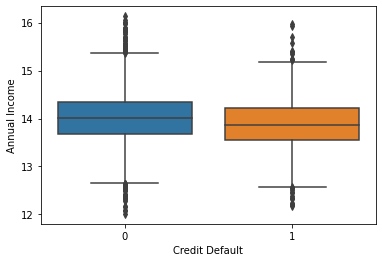

In [10]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Annual Income']));

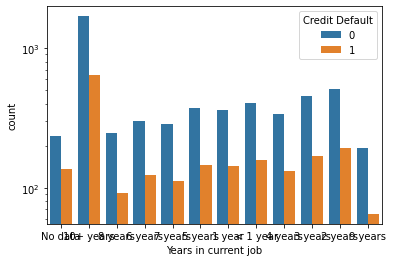

In [11]:
sns.countplot(train['Years in current job'].fillna('No data'), hue=train['Credit Default'], log=True);

In [12]:
train['Years in current job'].fillna('No data').value_counts(normalize=True)

10+ years    0.310933
2 years      0.094000
3 years      0.082667
< 1 year     0.075067
5 years      0.068800
1 year       0.067200
4 years      0.062533
6 years      0.056800
7 years      0.052800
No data      0.049467
8 years      0.045200
9 years      0.034533
Name: Years in current job, dtype: float64

In [13]:
train.groupby(train['Years in current job'].fillna('No data'))['Credit Default'].mean()

Years in current job
1 year       0.281746
10+ years    0.276158
2 years      0.273759
3 years      0.274194
4 years      0.279318
5 years      0.281008
6 years      0.291080
7 years      0.280303
8 years      0.271386
9 years      0.250965
< 1 year     0.282416
No data      0.369272
Name: Credit Default, dtype: float64

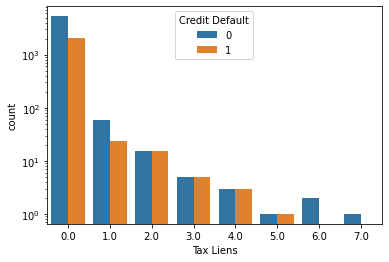

In [14]:
sns.countplot(train['Tax Liens'], hue=train['Credit Default'], log=True);

In [15]:
train['Tax Liens'].value_counts(normalize=True)

0.0    0.982133
1.0    0.011067
2.0    0.004000
3.0    0.001333
4.0    0.000800
5.0    0.000267
6.0    0.000267
7.0    0.000133
Name: Tax Liens, dtype: float64

In [16]:
train.groupby(['Tax Liens'])['Credit Default'].mean()

Tax Liens
0.0    0.280342
1.0    0.289157
2.0    0.500000
3.0    0.500000
4.0    0.500000
5.0    0.500000
6.0    0.000000
7.0    0.000000
Name: Credit Default, dtype: float64

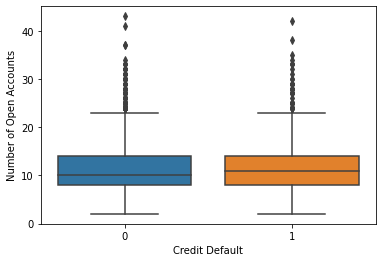

In [17]:
sns.boxplot(x=train['Credit Default'], y=(train['Number of Open Accounts']));

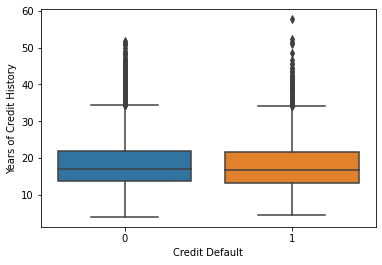

In [18]:
sns.boxplot(x=train['Credit Default'], y=(train['Years of Credit History']));

In [19]:
print(train[train['Years of Credit History'] > 55].shape[0])
train[train['Years of Credit History'] > 55].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
476,Home Mortgage,1076768.0,NaN,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1


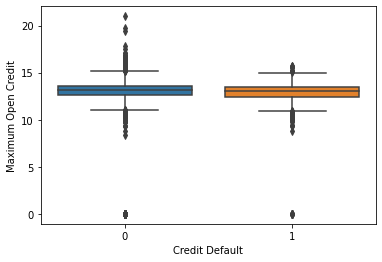

In [20]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Maximum Open Credit']));

In [21]:
print(train[np.log1p(train['Maximum Open Credit']) == 0].shape[0])
train[np.log1p(train['Maximum Open Credit']) == 0].head()

65


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


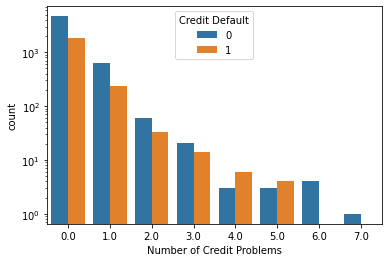

In [22]:
sns.countplot(train['Number of Credit Problems'], hue=train['Credit Default'], log=True);

In [23]:
train['Number of Credit Problems'].value_counts(normalize=True)

0.0    0.862533
1.0    0.117600
2.0    0.012400
3.0    0.004667
4.0    0.001200
5.0    0.000933
6.0    0.000533
7.0    0.000133
Name: Number of Credit Problems, dtype: float64

In [24]:
train.groupby(['Number of Credit Problems'])['Credit Default'].mean()

Number of Credit Problems
0.0    0.280569
1.0    0.273243
2.0    0.354839
3.0    0.400000
4.0    0.666667
5.0    0.571429
6.0    0.000000
7.0    0.000000
Name: Credit Default, dtype: float64

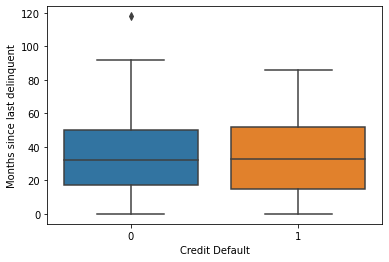

In [25]:
sns.boxplot(x=train['Credit Default'], y=train['Months since last delinquent']);

In [26]:
print(train[train['Months since last delinquent'] > 100].shape[0])
train[train['Months since last delinquent'] > 100].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4191,Home Mortgage,3009201.0,6 years,0.0,10.0,20.8,773322.0,0.0,118.0,0.0,debt consolidation,Short Term,449592.0,299877.0,15297.0,738.0,0


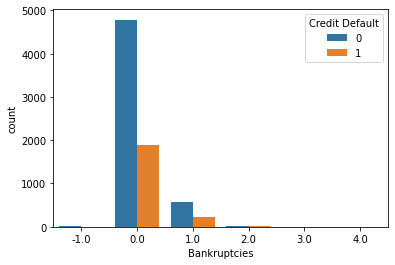

In [27]:
sns.countplot(train['Bankruptcies'].fillna(-1), hue=train['Credit Default']);

In [28]:
train['Bankruptcies'].fillna(-1).value_counts(normalize=True)

 0.0    0.888000
 1.0    0.104800
 2.0    0.004133
-1.0    0.001867
 3.0    0.000933
 4.0    0.000267
Name: Bankruptcies, dtype: float64

In [29]:
train.groupby(train['Bankruptcies'].fillna(-1))['Credit Default'].mean()

Bankruptcies
-1.0    0.285714
 0.0    0.281982
 1.0    0.276081
 2.0    0.354839
 3.0    0.285714
 4.0    0.500000
Name: Credit Default, dtype: float64

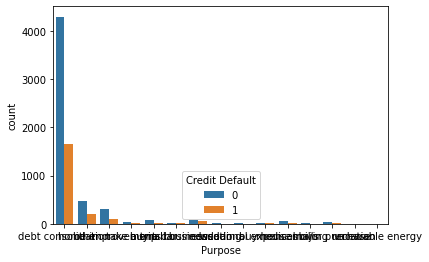

In [30]:
sns.countplot(train['Purpose'], hue=train['Credit Default']);

In [31]:
train['Purpose'].value_counts(normalize=True)

debt consolidation      0.792533
other                   0.088667
home improvements       0.054933
business loan           0.017200
buy a car               0.012800
medical bills           0.009467
major purchase          0.005333
take a trip             0.004933
buy house               0.004533
small business          0.003467
wedding                 0.002000
moving                  0.001467
educational expenses    0.001333
vacation                0.001067
renewable energy        0.000267
Name: Purpose, dtype: float64

In [32]:
train.groupby(['Purpose'])['Credit Default'].mean()

Purpose
business loan           0.426357
buy a car               0.250000
buy house               0.264706
debt consolidation      0.278264
educational expenses    0.100000
home improvements       0.262136
major purchase          0.225000
medical bills           0.309859
moving                  0.181818
other                   0.296241
renewable energy        1.000000
small business          0.538462
take a trip             0.270270
vacation                0.250000
wedding                 0.266667
Name: Credit Default, dtype: float64

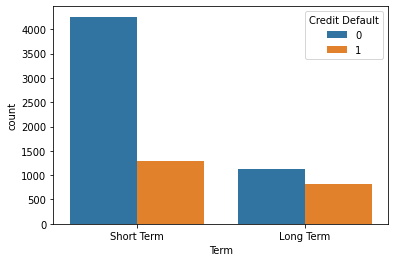

In [33]:
sns.countplot(train['Term'], hue=train['Credit Default']);

In [34]:
train['Term'].value_counts(normalize=True)

Short Term    0.7408
Long Term     0.2592
Name: Term, dtype: float64

In [35]:
train.groupby(['Term'])['Credit Default'].mean()

Term
Long Term     0.419753
Short Term    0.233441
Name: Credit Default, dtype: float64

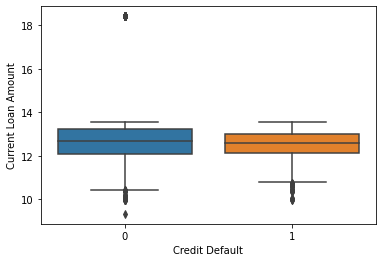

In [36]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Loan Amount']));

In [37]:
print(train[np.log1p(train['Current Loan Amount']) > 14].shape[0])
train[np.log1p(train['Current Loan Amount']) > 14].head()

870


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


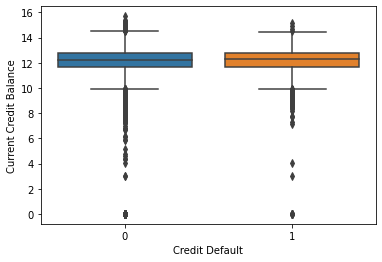

In [38]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Credit Balance']));

In [39]:
print(train[np.log1p(train['Current Credit Balance']) == 0].shape[0])
train[np.log1p(train['Current Credit Balance']) == 0].head()

53


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
319,Own Home,NaN,< 1 year,0.0,2.0,10.5,0.0,0.0,NaN,0.0,business loan,Short Term,76670.0,0.0,6432.0,NaN,0


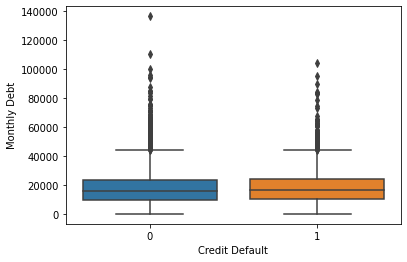

In [40]:
sns.boxplot(x=train['Credit Default'], y=(train['Monthly Debt']));

In [41]:
print(train[train['Monthly Debt'] > 120000].shape[0])
train[train['Monthly Debt'] > 120000].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0


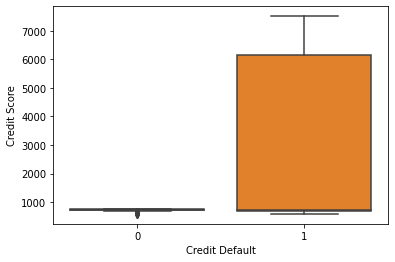

In [42]:
sns.boxplot(x=train['Credit Default'], y=(train['Credit Score']));

In [43]:
print(train[train['Credit Score'] > 1000].shape[0])
train[train['Credit Score'] > 1000].head()

400


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1


#### Обработка выбросов

In [44]:
train_wo_outliers = train[~train['Tax Liens'].isin([6, 7])].copy()
train_wo_outliers = train_wo_outliers[train_wo_outliers['Maximum Open Credit'] > 0]
train_wo_outliers = train_wo_outliers[np.log1p(train_wo_outliers['Maximum Open Credit']) <= 16]
train_wo_outliers = train_wo_outliers[~train_wo_outliers['Number of Credit Problems'].isin([6, 7])]
train_wo_outliers = train_wo_outliers[train_wo_outliers['Months since last delinquent'].fillna(0) <= 100]
train_wo_outliers = train_wo_outliers[np.log1p(train_wo_outliers['Current Loan Amount']) <= 14]
train_wo_outliers = train_wo_outliers[np.log1p(train_wo_outliers['Current Credit Balance']) > 0]
train_wo_outliers = train_wo_outliers[~train_wo_outliers['Purpose'].isin(['renewable energy'])]
train_wo_outliers = train_wo_outliers[train_wo_outliers['Monthly Debt'] <= 120000]

#### Предобработка данных

In [45]:
cat_features = list(train.select_dtypes(include=[object]).columns.values)
num_features = list(feature for feature in train.columns if feature not in cat_features )

In [46]:
def preproc(input_data, categorical_features=[]):
    
    output_data = input_data.copy()
    output_data['Annual Income'].fillna(-1, inplace=True)
    output_data['Years in current job'].fillna('No data', inplace=True)
    output_data['Credit Score'].fillna(-1, inplace=True)
    output_data['Months since last delinquent'].fillna(-1, inplace=True)
    output_data['Bankruptcies'].fillna(-1, inplace=True)
    
    if len(categorical_features) > 0:
        
        X = pd.get_dummies(output_data, columns=cat_features, drop_first=False).copy()
        
        if 'Credit Default' in X.columns:
            X.drop(['Credit Default'], axis=1, inplace=True)
            y = output_data['Credit Default'].values.copy()

            return X, y
        
        else:
            return X
    
    else:
        
        X = output_data.copy()
        
        if 'Credit Default' in X.columns:
            X.drop(['Credit Default'], axis=1, inplace=True)
            y = output_data['Credit Default'].values.copy()

            return X, y
        
        else:
            return X
        

In [47]:
X, y = preproc(train_wo_outliers, cat_features)

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6548 entries, 1 to 7499
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   6548 non-null   float64
 1   Tax Liens                       6548 non-null   float64
 2   Number of Open Accounts         6548 non-null   float64
 3   Years of Credit History         6548 non-null   float64
 4   Maximum Open Credit             6548 non-null   float64
 5   Number of Credit Problems       6548 non-null   float64
 6   Months since last delinquent    6548 non-null   float64
 7   Bankruptcies                    6548 non-null   float64
 8   Current Loan Amount             6548 non-null   float64
 9   Current Credit Balance          6548 non-null   float64
 10  Monthly Debt                    6548 non-null   float64
 11  Credit Score                    6548 non-null   float64
 12  Home Ownership_Have Mortgage    65

#### Отбор признаков

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [50]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [51]:
clf = LGBMClassifier(random_state=42)

rfecv = RFECV(clf, cv=skf, scoring='neg_log_loss', n_jobs=2)

rfecv.fit(X_train.values, y_train)

features = rfecv.support_

In [52]:
print(f'Из {X.shape[1]} отобрано {np.sum(features)} признаков')
print(X_train.loc[:, features].columns)

Из 44 отобрано 19 признаков
Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Home Ownership_Home Mortgage', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_No data', 'Purpose_business loan',
       'Purpose_debt consolidation', 'Purpose_other', 'Term_Long Term'],
      dtype='object')


#### Построение baseline модели

In [53]:
baseline = LGBMClassifier(n_estimators=100, max_depth=3, random_state=42)

baseline.fit(X_train.loc[:, features].values, y_train)

y_train_hat = baseline.predict(X_train.loc[:, features].values)
y_valid_hat = baseline.predict(X_valid.loc[:, features].values)

print(f'Train F1: {f1_score(y_train, y_train_hat)}')
print(f'Valid F1: {f1_score(y_valid, y_valid_hat)}')

Train F1: 0.492427943331705
Valid F1: 0.452914798206278


#### Подбор гиперпараметров

In [54]:
params = {
    'n_estimators': np.arange(100, 221, 10),
    'max_depth': np.arange(2, 7, 1),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': np.linspace(0.6, 0.95, 8),
    'colsample_bytree': np.linspace(0.6, 0.95, 8),
    'reg_alpha': np.linspace(0.1, 0.95, 18),
    'reg_lambda': np.linspace(0.1, 0.95, 18)
}

n = 4000

est = LGBMClassifier(n_estimators=100, max_depth=3, random_state=42)

rscv = RandomizedSearchCV(est, param_distributions=params, n_iter=n, cv=skf, 
                          scoring='neg_log_loss', random_state=42, n_jobs=2, verbose=True)

rscv.fit(X_train.loc[:, features].values, y_train)

print(rscv.best_score_)
print(rscv.best_params_)

Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   32.5s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1588 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 2488 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 3588 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 4888 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done 6388 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done 8088 tasks      | elapsed: 11.1min
[Parallel(n_jobs=2)]: Done 9988 tasks      | elapsed: 13.7min


-0.518341358079327
{'subsample': 0.85, 'reg_lambda': 0.7499999999999999, 'reg_alpha': 0.95, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}


[Parallel(n_jobs=2)]: Done 12000 out of 12000 | elapsed: 16.5min finished


#### Оценка качества модели

In [55]:
def get_threshold(y_true, y_proba, eps=0.001):

    ts = dict()

    for t in np.arange(0, 1, eps):
        y_hat = np.array(y_proba[:, 1] >= t).astype(int)
        ts[t] = f1_score(y_true, y_hat)

    sorted_ts = sorted(ts.items(), key=lambda x: -x[1])

    return sorted_ts[0][0]


#### Baseline model

In [56]:
y_train_proba = baseline.predict_proba(X_train.loc[:, features].values)
y_valid_proba = baseline.predict_proba(X_valid.loc[:, features].values)

t = get_threshold(y_train, y_train_proba)

print(f'Threshold t = {t}')

y_train_hat = np.array(y_train_proba[:, 1] >= t).astype(int)
y_valid_hat = np.array(y_valid_proba[:, 1] >= t).astype(int)

print(f'Train F1: {f1_score(y_train, y_train_hat)}')
print(f'Valid F1: {f1_score(y_valid, y_valid_hat)}')

Threshold t = 0.298
Train F1: 0.6184763047390521
Valid F1: 0.5474137931034482


#### Tuned model

In [57]:
y_train_proba = rscv.best_estimator_.predict_proba(X_train.loc[:, features].values)
y_valid_proba = rscv.best_estimator_.predict_proba(X_valid.loc[:, features].values)

t = get_threshold(y_train, y_train_proba)

print(f'Threshold t = {t}')

y_train_hat = np.array(y_train_proba[:, 1] >= t).astype(int)
y_valid_hat = np.array(y_valid_proba[:, 1] >= t).astype(int)

print(f'Train F1: {f1_score(y_train, y_train_hat)}')
print(f'Valid F1: {f1_score(y_valid, y_valid_hat)}')

Threshold t = 0.295
Train F1: 0.6158409967368733
Valid F1: 0.5538900785153461


#### Предсказание на тестовых данных

In [58]:
model = clone(rscv.best_estimator_)

model.fit(X.loc[:, features], y)

LGBMClassifier(colsample_bytree=0.8999999999999999, max_depth=3,
               random_state=42, reg_alpha=0.95, reg_lambda=0.7499999999999999,
               subsample=0.85)

In [59]:
X_test = preproc(test, cat_features)

In [60]:
y_test_proba = model.predict_proba(X_test.loc[:, features].values)
y_test_hat = np.array(y_test_proba[:, 1] >= t).astype(int)

In [61]:
predictions = pd.DataFrame()
predictions['Credit Default'] = y_test_hat

In [62]:
predictions.to_csv('TSasin_predictions.csv', index=True, encoding='utf-8')